In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_tuner as kt
import pathlib
import matplotlib.pyplot as plt
from tensorflow.data import experimental
import shutil
import random
import os

shutil.copytree(
    src="/kaggle/input/notebook7038392594/weather_cnn_tune",
    dst="/kaggle/working/weather_cnn_tune"
)

'/kaggle/working/weather_cnn_tune'

# Import Dataset, Oversample, Set up Data Pipeline

In [ ]:
#### === Setup ===
sandbox_dir = pathlib.Path("/kaggle/input/weather-dataset/Data/Weather_Dataset")
batch_size = 64
image_size = (224, 224)
seed = 1234
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# === Load the full dataset with batch_size=1 for easier splitting ===
full_dataset = tf.keras.utils.image_dataset_from_directory(
    sandbox_dir,
    labels='inferred',
    label_mode='int',
    seed=seed,
    image_size=image_size,
    batch_size=1,  # one sample per batch, each element is (image, label)
    shuffle=True
)

# Get number of classes (using the attribute from the dataset)
class_names = full_dataset.class_names
num_classes = len(class_names)
print("Found classes:", class_names)

# Determine total samples using cardinality
total_samples = full_dataset.cardinality().numpy()
print("Total samples:", total_samples)

# === Compute split sizes for 80% train, 10% validation, 10% test ===
train_count = int(total_samples * 0.8)
val_count = int(total_samples * 0.1)
test_count = total_samples - train_count - val_count
print("Train samples:", train_count, "Validation samples:", val_count, "Test samples:", test_count)

# === Split using take() and skip() ===
train_dataset = full_dataset.take(train_count)
remaining = full_dataset.skip(train_count)
val_dataset = remaining.take(val_count)
test_dataset = remaining.skip(val_count)

# === Unbatch to get individual samples ===
train_dataset = train_dataset.unbatch()
val_dataset = val_dataset.unbatch()
test_dataset = test_dataset.unbatch()

# === Convert tuples to dictionaries (to avoid dtype packing issues) ===
def tuple_to_dict(image, label):
    if image is None or label is None:
        raise ValueError("None encountered in tuple_to_dict")
    return {"image": image, "label": label}
    
train_dataset = train_dataset.map(tuple_to_dict, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset   = val_dataset.map(tuple_to_dict, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset  = test_dataset.map(tuple_to_dict, num_parallel_calls=tf.data.AUTOTUNE)

# === Oversample the minority classes in the training dataset ===
# Convert the training dataset to a list for oversampling.
train_list = list(train_dataset)
# After: train_list = list(train_dataset)
for i, example in enumerate(train_list):
    if example["image"] is None or example["label"] is None:
        print(f"Found None in sample {i}")

# Group samples by class.
samples_by_class = [[] for _ in range(num_classes)]
for example in train_list:
    # example is a dict with keys "image" and "label"
    # We use .numpy() to extract the integer label.
    label = int(example["label"].numpy())
    samples_by_class[label].append(example)

# Determine the maximum count among classes.
max_count = max(len(class_samples) for class_samples in samples_by_class)
print("Max samples among classes:", max_count)

# Replicate each class's samples to match the maximum count.
balanced_train_data = []
for class_samples in samples_by_class:
    n = len(class_samples)
    # Compute how many times to repeat the entire class and then take a remainder.
    repeats = max_count // n
    remainder = max_count % n
    balanced_samples = class_samples * repeats + class_samples[:remainder]
    balanced_train_data.extend(balanced_samples)

# Shuffle the balanced training data.
random.shuffle(balanced_train_data)

# Convert the balanced list back to a tf.data.Dataset.
# We create NumPy arrays for images and labels.
balanced_train_images = np.array([ex["image"].numpy() for ex in balanced_train_data])
balanced_train_labels = np.array([ex["label"].numpy() for ex in balanced_train_data])
train_dataset = tf.data.Dataset.from_tensor_slices({
    "image": balanced_train_images,
    "label": balanced_train_labels
})
print("Balanced training samples:", balanced_train_images.shape[0])

for i, ex in enumerate(balanced_train_data):
    if ex["image"] is None or ex["label"] is None:
        print(f"Found None value in sample {i}")

# === Define Data Augmentation for Training ===
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2)
])

def preprocess_train(example):
    # Convert image to float32 [0,1] and apply augmentation.
    image = tf.image.convert_image_dtype(example["image"], tf.float32)
    image = data_augmentation(image)
    return {"image": image, "label": example["label"]}

# Normalization function for validation and test sets.
def normalize(example):
    image = tf.image.convert_image_dtype(example["image"], tf.float32)
    return {"image": image, "label": example["label"]}

# === Build final dataset pipelines ===

def dict_to_tuple(example):
    return (example["image"], example["label"])

# Training: apply augmentation, cache, shuffle, repeat, batch, copy to GPU, and prefetch.
# Convert dictionaries to tuples to avoid issues with operations that expect uniform types.
train_dataset = train_dataset.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset   = val_dataset.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset  = test_dataset.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

# Now rebuild the final training pipeline (without copy_to_device, for instance)
train_dataset = (
    train_dataset
    .map(lambda img, lbl: (tf.image.convert_image_dtype(img, tf.float32), lbl),
         num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .shuffle(1000)
    .repeat()
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    val_dataset
    .map(lambda img, lbl: (tf.image.convert_image_dtype(img, tf.float32), lbl),
         num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_dataset
    .map(lambda img, lbl: (tf.image.convert_image_dtype(img, tf.float32), lbl),
         num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)


# Define CNN Model Building Function for Keras Tuner

In [3]:
def build_model(hp):
    # Clean the hyperparameters: remove keys starting with "tuner/" and any None values.
    hp_clean = {k: v for k, v in hp.values.items() if not k.startswith("tuner/") and v is not None}
    
    # Retrieve each hyperparameter, setting a default if it’s missing.
    activation = hp_clean.get("activation", "relu")
    optimizer_name = hp_clean.get("optimizer", "adam")
    l2_reg = hp_clean.get("l2_reg", 1e-3)
    
    conv_1_filters = hp_clean.get("conv_1_filters", 16)
    conv_1_kernel = hp_clean.get("conv_1_kernel", 3)
    use_batchnorm = hp_clean.get("use_batchnorm", False)
    
    conv_2_filters = hp_clean.get("conv_2_filters", 128)
    conv_2_kernel = hp_clean.get("conv_2_kernel", 3)
    
    use_third_conv = hp_clean.get("use_third_conv", False)
    if use_third_conv:
        conv_3_filters = hp_clean.get("conv_3_filters", 48)
        conv_3_kernel = hp_clean.get("conv_3_kernel", 3)
    
    dropout = hp_clean.get("dropout", 0.1)
    dense_units = hp_clean.get("dense_units", 192)
    learning_rate = hp_clean.get("learning_rate", 1e-3)
    
    # Begin building the model.
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=image_size + (3,)))
    
    # First Convolution Block
    model.add(tf.keras.layers.Conv2D(filters=conv_1_filters,
                                     kernel_size=conv_1_kernel,
                                     padding="same",
                                     kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    if use_batchnorm:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation(activation))
    model.add(tf.keras.layers.MaxPooling2D())
    
    # Second Convolution Block
    model.add(tf.keras.layers.Conv2D(filters=conv_2_filters,
                                     kernel_size=conv_2_kernel,
                                     padding="same",
                                     kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    if use_batchnorm:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation(activation))
    model.add(tf.keras.layers.MaxPooling2D())
    
    # Optional Third Convolution Block
    if use_third_conv:
        model.add(tf.keras.layers.Conv2D(filters=conv_3_filters,
                                         kernel_size=conv_3_kernel,
                                         padding="same",
                                         kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
        if use_batchnorm:
            model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(activation))
        model.add(tf.keras.layers.MaxPooling2D())
        model.add(tf.keras.layers.SpatialDropout2D(rate=0.25))
    
    # Replace Flatten with Global Average Pooling (GAP)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    
    # Dense Block with Dropout and L2 Regularization
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(units=dense_units,
                                    activation=activation,
                                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    
    # Output Layer
    model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))
    
    # Set up the optimizer
    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model


# Perform Hyperparameter Search

In [4]:
# Set up the Keras Tuner with Hyperband search
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=30,              
    factor=3,                
    hyperband_iterations=3,    
    executions_per_trial=1,
    project_name="weather_cnn_tune"
)


# Optional: early stopping callback to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

# Run the hyperparameter search
steps_per_epoch = (max_count * num_classes) // batch_size
validation_steps = val_dataset.cardinality().numpy()
print(steps_per_epoch)

tuner.search(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[stop_early]
)
    
# Retrieve the best hyperparameters found
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hps.values)

Reloading Tuner from ./weather_cnn_tune/tuner0.json
160
Best Hyperparameters:
{'activation': 'gelu', 'optimizer': 'adam', 'l2_reg': 0.0011899264997203638, 'conv_1_filters': 16, 'conv_1_kernel': 7, 'use_batchnorm': False, 'conv_2_filters': 128, 'conv_2_kernel': 3, 'use_third_conv': True, 'dropout': 0.1, 'dense_units': 192, 'learning_rate': 0.001, 'conv_3_filters': 48, 'conv_3_kernel': 3, 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0074'}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - accuracy: 0.1617 - loss: 4.0522 - val_accuracy: 0.4942 - val_loss: 1.7551
Epoch 2/150
  2/160 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.4492 - loss: 1.7710

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.4208 - loss: 1.7964 - val_accuracy: 0.5569 - val_loss: 1.5207
Epoch 3/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.4872 - loss: 1.6035 - val_accuracy: 0.5364 - val_loss: 1.5618
Epoch 4/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.5237 - loss: 1.5026 - val_accuracy: 0.6706 - val_loss: 1.2421
Epoch 5/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.5673 - loss: 1.3812 - val_accuracy: 0.6647 - val_loss: 1.2438
Epoch 6/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.5905 - loss: 1.3251 - val_accuracy: 0.6910 - val_loss: 1.1895
Epoch 7/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.6137 - loss: 1.2569 - val_accuracy: 0.6006 - val_loss: 1.3262
Epoch 8/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.6090 - loss: 1.2714 - val_accuracy: 0.6603 - val_loss: 1.1783
Epoch 9/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.6375 - loss: 1.1908 - val_

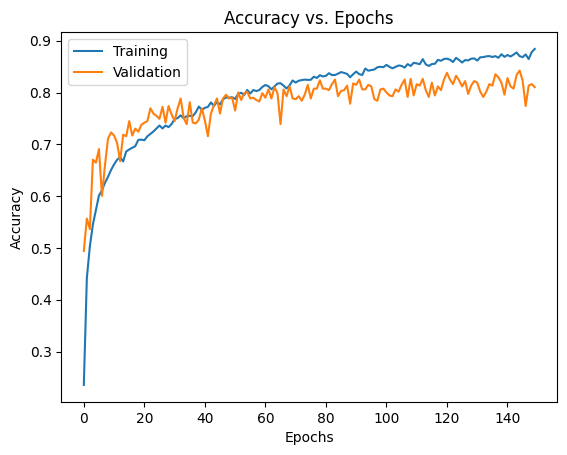

In [5]:
import os
import json
import joblib

# === Create output directory ===
output_dir = "model_output"
os.makedirs(output_dir, exist_ok=True)

# === Early stopping ===
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# === Train the best model ===
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    epochs=150,
)

# === Save model weights and architecture ===
model_path = os.path.join(output_dir, "best_model.h5")
best_model.save(model_path)
print(f"✅ Saved trained model to: {model_path}")

# === Save best hyperparameters ===
hparams_path = os.path.join(output_dir, "best_hyperparameters.json")
with open(hparams_path, "w") as f:
    json.dump(best_hps.values, f, indent=2)
print(f"✅ Saved best hyperparameters to: {hparams_path}")

# === Save training history ===
history_path = os.path.join(output_dir, "training_history.json")
with open(history_path, "w") as f:
    json.dump(history.history, f, indent=2)
print(f"✅ Saved training history to: {history_path}")

# === Visualize training ===
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Training", "Validation"], loc="upper left")
plt.show()


# Perform Threshold Tuning

In [6]:
# --- Collect Ground Truth Labels and Model Predictions from val_dataset ---
val_true = []
val_pred_prob = []

for batch in val_dataset:
    images, labels = batch
    val_true.extend(labels.numpy())
    preds = best_model.predict_on_batch(images)
    val_pred_prob.extend(preds)

val_true = np.array(val_true)
val_pred_prob = np.array(val_pred_prob)

# --- Tune thresholds per class using validation accuracy ---
thresholds = np.linspace(0.0, 1.0, 200)
best_thresholds = []

for i in range(num_classes):
    best_acc = 0
    best_t = 0.5
    for t in thresholds:
        preds = []
        for row in val_pred_prob:
            if row[i] >= t:
                pred = i
            else:
                pred = np.argmax(row)
            preds.append(pred)
        acc = np.mean(np.array(preds) == val_true)
        if acc > best_acc:
            best_acc = acc
            best_t = t
    best_thresholds.append(best_t)

print("Best thresholds (val-based):", best_thresholds)



Best thresholds (val-based): [0.3969849246231156, 0.2663316582914573, 0.4120603015075377, 0.21105527638190955, 0.09045226130653267, 0.2914572864321608, 0.4120603015075377, 0.3316582914572864, 0.2763819095477387, 0.24623115577889448, 0.31155778894472363]


# Evaluate Best Model on Test Data

🔹 Unthresholded Predictions (Argmax)
Accuracy: 0.8210
Macro F1 Score: 0.8270
ROC AUC (OvR): 0.9834

Classification Report (Argmax):
              precision    recall  f1-score   support

         dew       0.91      0.92      0.92        66
     fogsmog       0.85      0.89      0.87        81
       frost       0.75      0.80      0.77        55
       glaze       0.86      0.68      0.76        74
        hail       0.84      0.78      0.81        54
   lightning       0.85      1.00      0.92        41
        rain       0.71      0.89      0.79        65
     rainbow       1.00      0.94      0.97        18
        rime       0.80      0.81      0.80       113
   sandstorm       0.90      0.92      0.91        66
        snow       0.69      0.50      0.58        54

    accuracy                           0.82       687
   macro avg       0.83      0.83      0.83       687
weighted avg       0.82      0.82      0.82       687


🔹 Thresholded Predictions
Accuracy: 0.8224
Macro F1 Sc

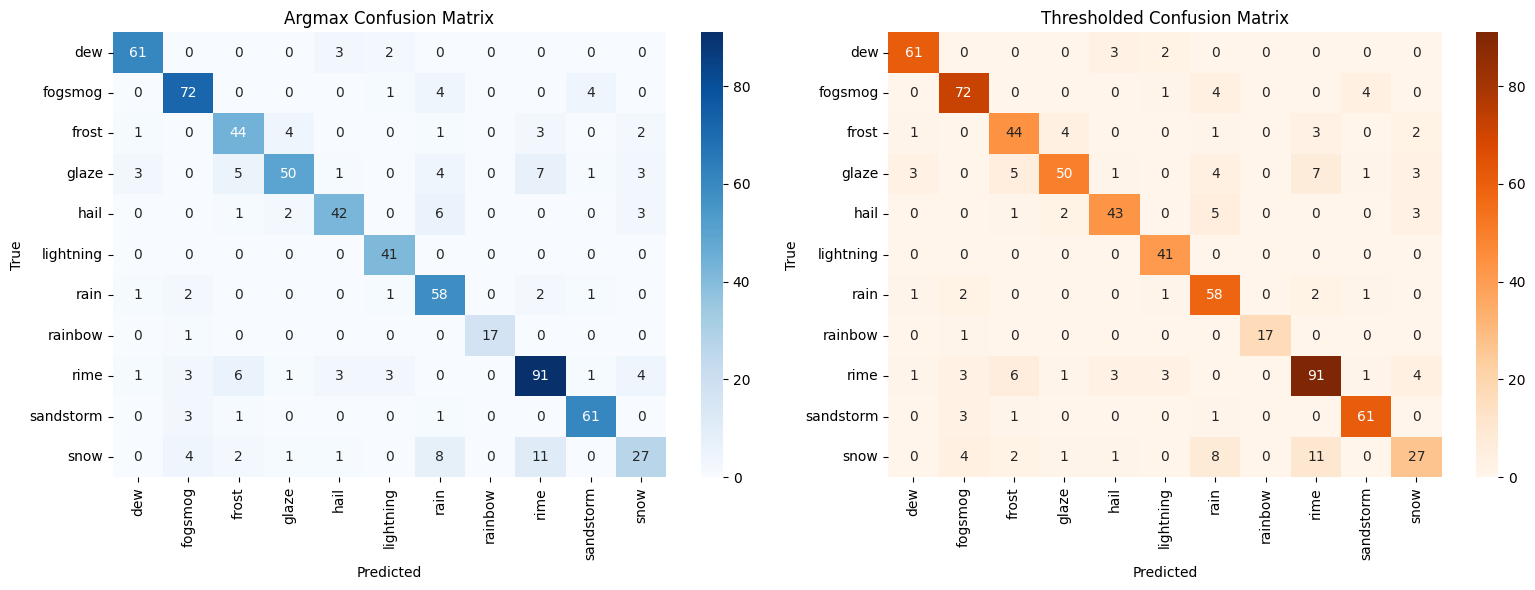

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def predict_with_thresholds(y_prob, thresholds):
    preds = []
    for row in y_prob:
        valid_classes = [i for i, p in enumerate(row) if p >= thresholds[i]]
        if valid_classes:
            pred = valid_classes[np.argmax([row[i] for i in valid_classes])]
        else:
            pred = np.argmax(row)
        preds.append(pred)
    return np.array(preds)

# Collect ground truth labels and predicted probabilities from test dataset
y_true = []
y_pred_prob = []

for batch in test_dataset:
    images, labels = batch
    y_true.extend(labels.numpy())
    preds = best_model.predict_on_batch(images)
    y_pred_prob.extend(preds)

y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Binarize true labels for multiclass ROC AUC
y_true_bin = label_binarize(y_true, classes=range(num_classes))

# --- 1. Argmax (Unthresholded) Predictions ---
y_pred_argmax = np.argmax(y_pred_prob, axis=1)

acc_argmax = np.mean(y_pred_argmax == y_true)
f1_argmax = f1_score(y_true, y_pred_argmax, average='macro')
roc_auc_argmax = roc_auc_score(y_true_bin, y_pred_prob, multi_class='ovr')

print("🔹 Unthresholded Predictions (Argmax)")
print(f"Accuracy: {acc_argmax:.4f}")
print(f"Macro F1 Score: {f1_argmax:.4f}")
print(f"ROC AUC (OvR): {roc_auc_argmax:.4f}")
print("\nClassification Report (Argmax):")
print(classification_report(y_true, y_pred_argmax, target_names=class_names))

# --- 2. Thresholded Predictions ---
y_pred_thresh = predict_with_thresholds(y_pred_prob, best_thresholds)

acc_thresh = np.mean(y_pred_thresh == y_true)
f1_thresh = f1_score(y_true, y_pred_thresh, average='macro')
roc_auc_thresh = roc_auc_score(y_true_bin, y_pred_prob, multi_class='ovr')  # Same as above

print("\n🔹 Thresholded Predictions")
print(f"Accuracy: {acc_thresh:.4f}")
print(f"Macro F1 Score: {f1_thresh:.4f}")
print(f"ROC AUC (OvR): {roc_auc_thresh:.4f}")
print("\nClassification Report (Thresholded):")
print(classification_report(y_true, y_pred_thresh, target_names=class_names))

# --- 3. Side-by-Side Confusion Matrices ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Argmax
cm_argmax = confusion_matrix(y_true, y_pred_argmax)
sns.heatmap(cm_argmax, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title("Argmax Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# Thresholded
cm_thresh = confusion_matrix(y_true, y_pred_thresh)
sns.heatmap(cm_thresh, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_title("Thresholded Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()
